# **INITIAL SETUP**

## MODULES

In [270]:
import math
import numpy as np
from scipy import signal, stats
import matplotlib.pyplot as plt
import seaborn as sns
import collections

In [271]:
import warnings
warnings.filterwarnings('ignore')

## GRAPH STYLE

In [272]:
sns.set_theme(style="darkgrid")
sns.set(style="ticks", context="talk")

In [273]:
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (25, 5)

In [274]:
X_TICK_SCALE = 26

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 16

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True

## CONSTANTS

In [275]:
SET = {              # DATA SETS (date {"YYYY.MM.DD"}, NUM_COMPACTIONS, COMPLETION_COMPACTION)
    "Masado": [("2020.12.23", 7), ("2021.1.28", 5), ("2021.2.3", 6, 6), ("2021.2.5", 6, 5)],
    "Nenseido": [("2020.12.23", 7), ("2021.1.21", 6), ("2021.2.4", 5, 2), ("2021.2.6", 5, 2)],
    "Rekishitudo": [("2020.12.23", 7), ("2021.2.4", 6, 5), ("2021.2.5", 6, 6), ("2021.3.11", 3, 2)]
}

SOIL = {
    1: "Masado",     # マサド
    2: "Nenseido",   # 粘性土
    3: "Rekishitudo" # 礫土
}

COMPONENT = {        # DATA CHANNELS NAMING
    1: "ACC_X",      # CH1 - ACC_X
    2: "ACC_Y",      # CH2 - ACC_Y
    3: "ACC_Z",      # CH3 - ACC_Z
    4: "AUDIO"       # CH4 - AUDIO
}

COLOR = {            # GRAPHS COLORING
    0: "#aa0000",    # Idling       - Red
    1: "#ffa500",    # Compaction 1 - Orange
    2: "#eeee00",    # Compaction 2 - Yellow
    3: "#00cc00",    # Compaction 3 - Green
    4: "#ffffff",    # Compaction 4 - White
    5: "#cc00aa",    # Compaction 5 - Magenta
    6: "#39ff14",    # Compaction 6 - Neon
    7: "#aaaa00"     # Compaction 7 - Moss Green
}

> NOTE: 2021.2.3_MASADO has non-conforming data labelling

```DATE_INDEXs FOR RELIABLE DATA```

- Masado - 3, 4
- Nenseido - 3, 4
- Rekishitudo - 2, 3, `4` <-> most reliable

In [276]:
# FMAX = 639.99
FF = 51 # 51Hz

## Basic Functions

In [277]:
def set(soil_index, date_index):
    # Assume final compaction as completion compaction if completion compaction is not provided
    RET_3 = SET[SOIL[soil_index]][date_index-1][2] if len(SET[SOIL[soil_index]][date_index-1]) == 3 else SET[SOIL[soil_index]][date_index-1][1]

    return f"{SET[SOIL[soil_index]][date_index-1][0]}_{SOIL[soil_index]}", SET[SOIL[soil_index]][date_index-1][1], RET_3

In [278]:
def cout(message, log):
    if log: print(message)

---

# **DATA MANIPULATION FUNCTIONS**

## FFT

Computer the Fast Fourier Transform

> - Returns the Power Spectral Density

In [279]:
def fft (t, v, normalization_factor = 1):
    """ Fast Fourier Transform """
    n = len(t)                                                                                          # Sample size
    dt = np.average(np.diff(t))                                                                         # Sampling gap
    fs = 1/dt                                                                                           # Sampling frequency (fs)
    f = np.arange(n//2) / n / dt                                                                        # Frequency domain frequencies, also => np.fft.fftfreq(n//2, dt)
    v_bar = np.fft.fft(v)                                                                               # Fast Fourier Transform
    v_bar = v_bar[:n//2]                                                                                # Nyquist Shannon Theorem => ∀f > fs/2 !v_bar[f]
    v_bar = np.sqrt(v_bar * np.conj(v_bar)) * 2 / n  * normalization_factor                             # Power Spectrum Density
    return f, abs(v_bar)

## WELCH METHOD

``` Estimates filtered (smoothened) Power Spectral Density ```


> - nperseg - increase by power of 2 to increase resolution

In [280]:
def welch(t, v, nperseg=2**13):
    """ Power Spectrum Density estimation using Welch's method """
    dt = np.average(np.diff(t))                                                                         # Sampling gap
    fs = 1/dt                                                                                           # Sampling frequency (fs)
    f, v_bar = signal.welch(v, fs=fs, window='hamming', nperseg=nperseg, noverlap=0)                    # Power Spectrum Density
    return f, abs(v_bar)

## FIND_K

``` Finds the frequency with the maximum amplitude in a given interval ```

In [281]:
def find_k(f, v_bar, k=1):
    """ Finds k frequencies with the maximum amplitude in a given interval """
    k_indices = np.argsort(v_bar)[-k:] # np.argpartition(v_bar, range(len(v_bar)-k, len(v_bar)))[-k:]    
    v_bar_dash = np.zeros(v_bar.size)
    v_bar_dash[k_indices] = v_bar[k_indices]
    return f, v_bar_dash, f[k_indices]

In [282]:
def find_h(f, v_bar):
    """ Finds the frequency with the maximum amplitude in a given interval """
    index = np.argmax(v_bar)
    v_bar_dash = np.zeros(v_bar.size)
    v_bar_dash[index] = v_bar[index]
    return f, v_bar_dash, f[index]

## BANDPASS FILTER *(HARD)*

> - Takes frequency domain data pair as input

In [283]:
def bpf(f, v_bar, lth=0, hth=-1):
    """ Bandpass Filter """
    if hth == -1: 
        return f[np.argmax(f>lth):], v_bar[np.argmax(f>lth):]
    else: 
        return f[np.argmax(f>lth):np.argmax(f>hth)], v_bar[np.argmax(f>lth):np.argmax(f>hth)]

## BANDPASS FILTER *(GRADUAL)*

>  - `Using Butterworth second order section`
>  - Takes time domain data pair as input 

In [284]:
def bbpf(t, v, lth=0, hth=-1, order=5):
    """ Butter Bandpass Filter """
    dt = np.average(np.diff(t))                                                                         # Sampling gap
    fs = 1/dt                                                                                           # Sampling frequency (fs)
    nyq = 0.5 * fs                                                                                      # Nyquist frequency = fs/2
    if hth == -1: hth = nyq
    sos = signal.butter(order, [lth / nyq, hth / nyq], analog=False, btype='band', output='sos')        # Cascaded second order sections
    x_filt = signal.sosfiltfilt(sos, v)                                                                 # Forward-backward digital filter
    return t, x_filt

---

# GRAPHING FUNCTIONS

> - `n` - compaction *(1 to 6)*
> - `c` - data value
>     - 1 - ACC_X
>     - 2 - ACC_Y
>     - 3 - ACC_Z
>     - 4 - AUDIO
> - `lth` - Lower frequency value for the bandpassfilter 
> - `hth` - Higher frequency value for the bandpassfilter
>         - set as -1 to set as maximum
>         - < 640
> - `ft` - Transform method to use
>     - Set as `fft` to use *FFT*                - more noise, but highest resolution
>     - Set as `welch` to use *Welch Estimation* - lower noise (set high *nperseg* to improve resolution if required)
> - `style` - Graph scale
>      - Set as `"log"` to use a logarithmic scale for the graph
>      - Set as `"lin"` to use a linear scale for the graph

## graph()

Graph FFT and Welch transforms in the same graph

In [285]:
def graph(soil_index, date_index, compaction_index, component_index=1, lth=X_TICK_SCALE, hth=-1, ft = welch, style = "log"): # style = ["log"|"lin"]
    """ Graph FFT and Welch in the same plot """
    PATH, NUM_COMPACTIONS, COMP_COMPACTIONS = set(soil_index, date_index)
    t, *v = np.genfromtxt(f'data/{PATH}/CLEANED/{compaction_index}.csv', delimiter=',', unpack=True)

    if style == "log": plt.semilogy(*bpf(*ft(t, v[component_index-1]), lth, hth), label = compaction_index, color = COLOR[compaction_index])
    else: plt.plot(*bpf(*ft(t, v[component_index-1]), lth, hth), label = f"{compaction_index}", color = COLOR[compaction_index])

    plt.xlabel("Hz")
    plt.ylabel("Pa" if component_index == 4 else "m/s²")
    
    plt.title(f"{(ft.__name__).upper()} | {style.upper()} | {PATH} - Compaction {compaction_index} | {COMPONENT[component_index]} | {lth} Hz - {hth if hth > 0 else 'MAX'} Hz")

In [286]:
# plt.title(f"TITLE")
# plt.legend(loc='best')
# plt.tight_layout()

## wave()

Graph *Wave* data for a given compaction

In [287]:
# def wave(soil_index, date_index, compaction_index, component_index=1, lth=X_TICK_SCALE, hth=-1):
#     """ Graph the Wave data """
#     PATH, NUM_COMPACTIONS, COMP_COMPACTIONS = set(soil_index, date_index)
#     plt.semilogy(*bpf(*np.genfromtxt(f'data/{PATH}/CLEANED/Wave_{compaction_index}{component_index}.csv', delimiter=',', unpack = True), lth, hth), color = COLOR[compaction_index]) #, label = f"WAVE_{compaction_index} | {COMPONENT[component_index]}")
#     plt.title(f"{PATH} - Compaction {compaction_index} | {COMPONENT[component_index]} | {lth} Hz - {hth if hth > 0 else 'MAX'} Hz")
#     plt.legend(loc='best')
#     plt.tight_layout()
#     plt.xticks(np.arange(lth, hth+1, X_TICK_SCALE))
#     plt.grid(color='gray', linestyle=':')
#     plt.xlabel("Hz")
#     plt.ylabel("Pa" if component_index == 4 else "m/s²")

## compare_graph()

Compare FFT, Welch, and Wave frequency domain data in different graphs

In [288]:
# def compare_graph(soil_index, date_index, compaction_index, component_index=1, lth=X_TICK_SCALE, hth=-1):
#     """ Compare FFT, Welch, and Wave frequency domain data in different graphs """
#     PATH, NUM_COMPACTIONS, COMP_COMPACTIONS = set(soil_index, date_index)
#     fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, sharex = True)
#     t, *v = np.genfromtxt(f'data/{PATH}/CLEANED/{compaction_index}.csv', delimiter=',', unpack=True)
#     ax1.semilogy(*bpf(*fft(t, v[component_index-1]), lth, hth), color = COLOR[compaction_index]) #, label = f"FFT_{compaction_index} | {COMPONENT[component_index]}")
#     ax2.semilogy(*bpf(*welch(t, v[component_index-1]), lth, hth), color = COLOR[compaction_index]) #, label = f"WELCH_{compaction_index} | {COMPONENT[component_index]}")
#     ax3.semilogy(*bpf(*np.genfromtxt(f'data/{PATH}/CLEANED/Wave_{compaction_index}{component_index}.csv', delimiter=',', unpack = True), lth, hth), color = COLOR[compaction_index]) #, label = f"WAVE_{compaction_index} | {COMPONENT[component_index]}")
#     plt.title(f"{PATH} - Compaction {compaction_index} | {COMPONENT[component_index]} | {lth} Hz - {hth if hth > 0 else 'MAX'} Hz")
#     plt.legend(loc='best')
#     plt.tight_layout()
#     plt.xticks(np.arange(lth, hth+1, X_TICK_SCALE))
#     plt.grid(color='gray', linestyle=':')
#     plt.xlabel("Hz")
#     plt.ylabel("Pa" if component_index == 4 else "m/s²")

## listk()

> Plot the highest frequency in the given frequency interval for every compaction
>> - `visual_m` - Set *False* to omit the graph 
>> - `ft` - Transform method to use
>>     - Set as `fft` to use *FFT*                - more noise, but highest resolution
>>     - Set as `welch` to use *Welch Estimation* - lower noise (set high *nperseg* to improve resolution if required)
>> - `style` - Graph scale
>>      - Set as `"log"` to use a logarithmic scale for the graph
>>      - Set as `"lin"` to use a linear scale for the graph

``` The function prints the frequencies (and their corresponding compactions) sorted in ascending order ```

In [289]:
def listk(soil_index, date_index, component_index=1, lth=X_TICK_SCALE, hth=-1, limit_on_completion=-1, ignore=[None], ft=welch, style="log", log=True, visual_g=False, visual_m=True):
    PATH, NUM_COMPACTIONS, COMP_COMPACTIONS= set(soil_index, date_index)

    if limit_on_completion < 0: LIMIT_COMPACTIONS = NUM_COMPACTIONS
    elif limit_on_completion == 0: LIMIT_COMPACTIONS = COMP_COMPACTIONS
    elif limit_on_completion < NUM_COMPACTIONS: LIMIT_COMPACTIONS = limit_on_completion
    else: LIMIT_COMPACTIONS = NUM_COMPACTIONS

    data = np.array([None] * LIMIT_COMPACTIONS)
    fk = np.array([None] * LIMIT_COMPACTIONS)
    
    cout(f"******************************************************** {COMPONENT[component_index]} ********************************************************", log)
    for compaction_index in range(0, LIMIT_COMPACTIONS):
        data[compaction_index] = np.genfromtxt(f'data/{PATH}/CLEANED/{compaction_index+1}.csv', delimiter=',', unpack=True)
        *vb, fk[compaction_index] = find_k(*bpf(*ft(data[compaction_index][0], data[compaction_index][component_index-1]), lth, hth))
        if visual_m and compaction_index+1 not in ignore: 
            if style == "log": plt.semilogy(*vb, label = None if visual_g else f"{compaction_index+1}", color = COLOR[compaction_index+1]) # 
            else: plt.plot(*vb, label = None if visual_g else f"{compaction_index+1}", color = COLOR[compaction_index+1])
#             cout(f"->> [{compaction_index+1}] {fk[compaction_index]}", log) # {', '.join(str(f) for f in fk[compaction_index])}
    
    if visual_m and not visual_g:
        plt.title(f"{(ft.__name__).upper()} | {style.upper()} | {PATH} | {COMPONENT[component_index]} | {lth} Hz - {hth if hth > 0 else 'MAX'} Hz")
        plt.legend(loc='best')
        plt.tight_layout()
        plt.xticks(np.arange(lth, hth+1, X_TICK_SCALE))
        plt.grid(color='gray', linestyle=':')
        plt.xlabel("Hz")
        plt.ylabel("Pa" if component_index == 4 else "m/s²")

    cout(f"< > Sorted Frequencies (left to right compactions) - [{', '.join(map(lambda x:(' %5s   '%str(x + 1)), np.argsort(fk)))}]", log)
    cout(f"< > Sorted Frequencies (low to high frequencies)   - [{', '.join(map(lambda x:('%9s'%('%.5f'%x)), fk[np.argsort(fk)]))}]", log)
    
    return np.argsort(fk), fk

## `compose()`

> Use this function to experiment 

In [290]:
def compose(soil_index, date_index, component_index=1, lth=X_TICK_SCALE, hth=-1, limit_on_completion=-1, ignore=[None], ft=welch, style="log", log=True, visual_g=True, visual_m=False):
    PATH, NUM_COMPACTIONS, COMP_COMPACTIONS = set(soil_index, date_index)

    if limit_on_completion < 0: LIMIT_COMPACTIONS = NUM_COMPACTIONS
    elif limit_on_completion == 0: LIMIT_COMPACTIONS = COMP_COMPACTIONS
    elif limit_on_completion < NUM_COMPACTIONS: LIMIT_COMPACTIONS = limit_on_completion
    else: LIMIT_COMPACTIONS = NUM_COMPACTIONS

    pattern, fk = listk(soil_index, date_index, component_index, lth, hth, limit_on_completion, ignore, ft, style, log, visual_g, visual_m)

    if visual_g: 
        for compaction_index in range(0, LIMIT_COMPACTIONS):
            if compaction_index+1 not in ignore:
                graph(soil_index, date_index, compaction_index+1, component_index, lth, hth, ft, style)

        plt.title(f"{(ft.__name__).upper()} | {style.upper()} | {PATH} | {COMPONENT[component_index]} | {lth} Hz - {hth if hth > 0 else 'MAX'} Hz")
        plt.legend(loc='best')
        plt.tight_layout()
        plt.xticks(np.arange(lth, hth+1, X_TICK_SCALE))
        plt.grid(color='gray', linestyle=':')
        plt.xlabel("Hz")
        plt.ylabel("Pa" if component_index == 4 else "m/s²")

    return ''.join(map(lambda x:str(x + 1), pattern))

---

# **GRAPHS**

Ranges of interest are handpicked based on observations from the graphs. They are written under their component headings.  
Please follow these examples to see how to read them.

> `X6 = [52, 257, 397]` implies that the ranges of interest for `ACC_X` are 
>> - `[52 - 6 , 52 + 6]`   = `[46, 58] Hz`
>> - `[257 - 6 , 257 + 6]` = `[251, 263] Hz`
>> - `[397 - 6 , 397 + 6]` = `[391, 403] Hz`

> `Y3 = [397, 404]` implies that the ranges of interest for `ACC_Y` are 
>> - `[397 - 3 , 397 + 3]` = `[394, 400] Hz`
>> - `[404 - 3 , 404 + 3]` = `[401, 407] Hz`

The following are the frequency domain graphs around the points of interest for each for the data components.

---

In [205]:
OVERTONES = [52, 103, 155, 206, 257, 310, 360]

---

## TIME DOMAIN GRAPHS

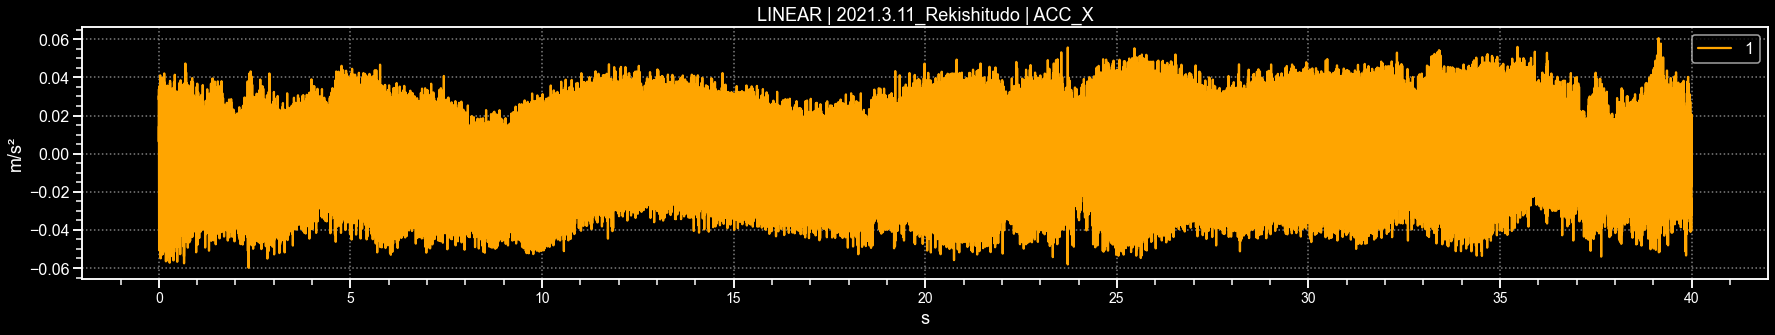

In [294]:
ai = 1
oi = 1

PATH, NUM_COMPACTIONS, COMP_COMPACTIONS = set(3, 4)
raw_data = np.genfromtxt(f'data/{PATH}/CLEANED/{ai}.csv', delimiter=',', unpack=True)
plt.plot(raw_data[0], raw_data[ai], label = ai, color = COLOR[ai])

plt.xlabel("s")
plt.ylabel("Pa" if oi == 4 else "m/s²")
plt.title(f"LINEAR | {PATH} | {COMPONENT[oi]}")
plt.legend(loc='best')
plt.tight_layout()
# plt.xticks(np.arange(1, NUM_COMPACTIONS+1, 1))
plt.grid(color='gray', linestyle=':')

plt.show()

## FREQUENCY DOMAIN GRAPHS

In [295]:
LTH = X_TICK_SCALE * int(1 * 1)
HTH = X_TICK_SCALE * int(46/ 1)
ft = welch
vm = True

******************************************************** ACC_X ********************************************************
< > Sorted Frequencies (left to right compactions) - [     1   ,      2   ,      3   ]
< > Sorted Frequencies (low to high frequencies)   - [ 26.25000,  26.25000,  26.25000]


'123'

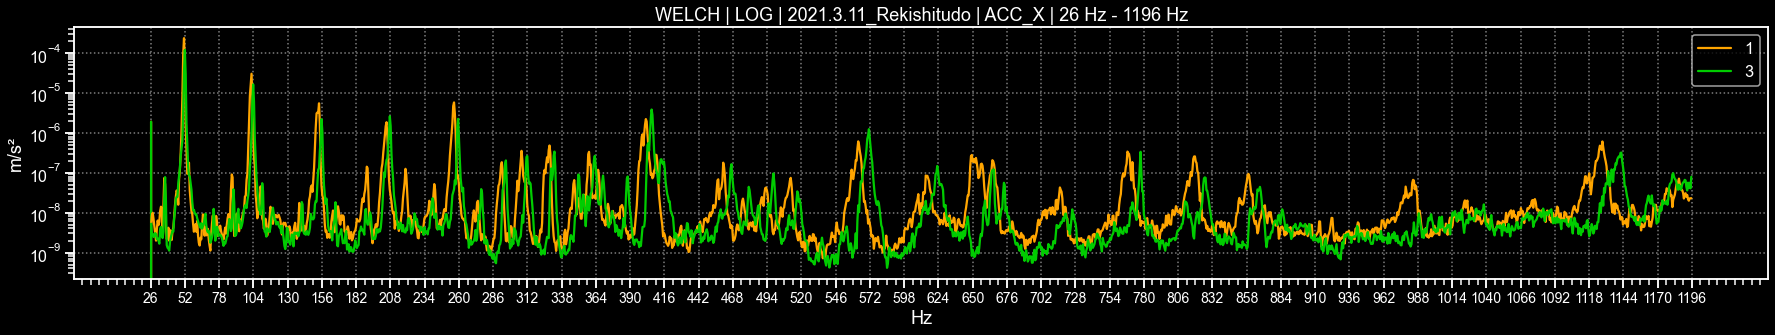

In [296]:
# graph(3, 4, 0, 1, LTH, HTH, ft=ft)
compose(3, 4, 1, LTH, HTH, ignore=[2], visual_m=vm, ft=ft)

******************************************************** ACC_Y ********************************************************
< > Sorted Frequencies (left to right compactions) - [     2   ,      1   ,      3   ]
< > Sorted Frequencies (low to high frequencies)   - [ 43.12500,  51.25000,  51.87500]


'213'

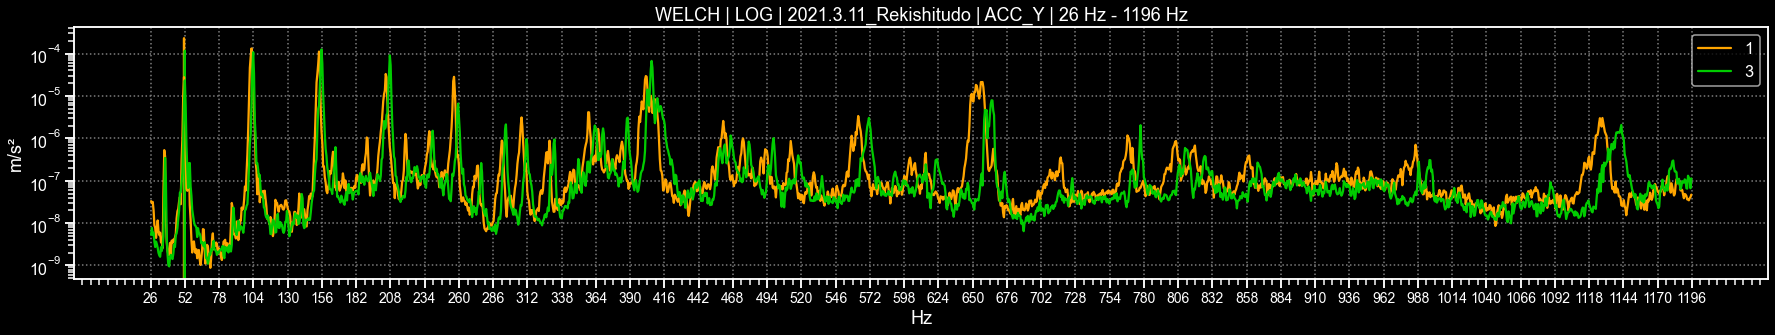

In [297]:
# graph(3, 4, 0, 2, LTH, HTH, ft=ft)
compose(3, 4, 2, LTH, HTH, ignore=[2], visual_m=vm, ft=ft)

******************************************************** ACC_Z ********************************************************
< > Sorted Frequencies (left to right compactions) - [     2   ,      1   ,      3   ]
< > Sorted Frequencies (low to high frequencies)   - [ 43.12500, 102.50000, 155.62500]


'213'

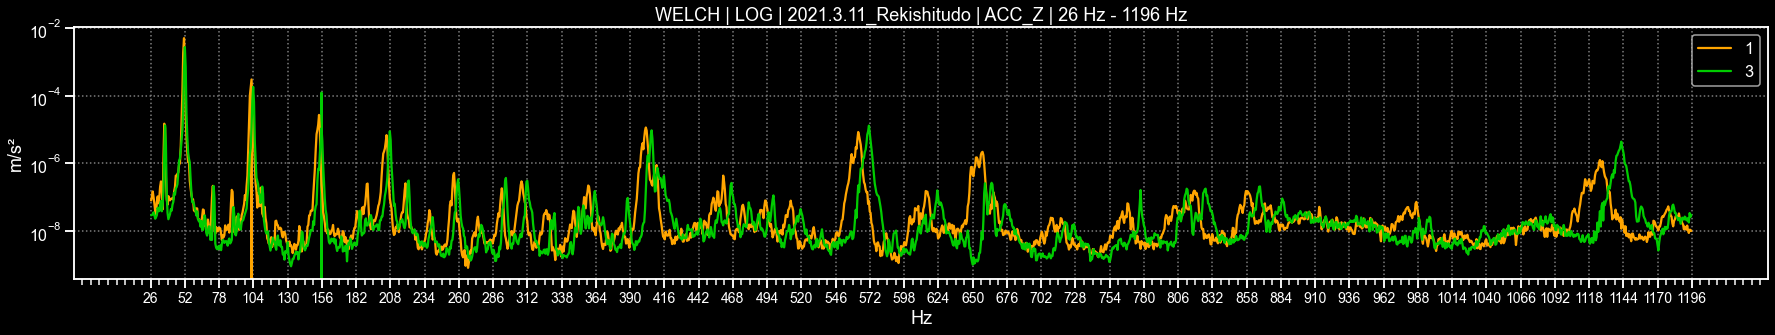

In [298]:
# graph(3, 4, 0, 3, LTH, HTH, ft=ft)
compose(3, 4, 3, LTH, HTH, ignore=[2], visual_m=vm, ft=ft)

******************************************************** AUDIO ********************************************************
< > Sorted Frequencies (left to right compactions) - [     2   ,      1   ,      3   ]
< > Sorted Frequencies (low to high frequencies)   - [ 43.12500,  51.25000,  51.87500]


'213'

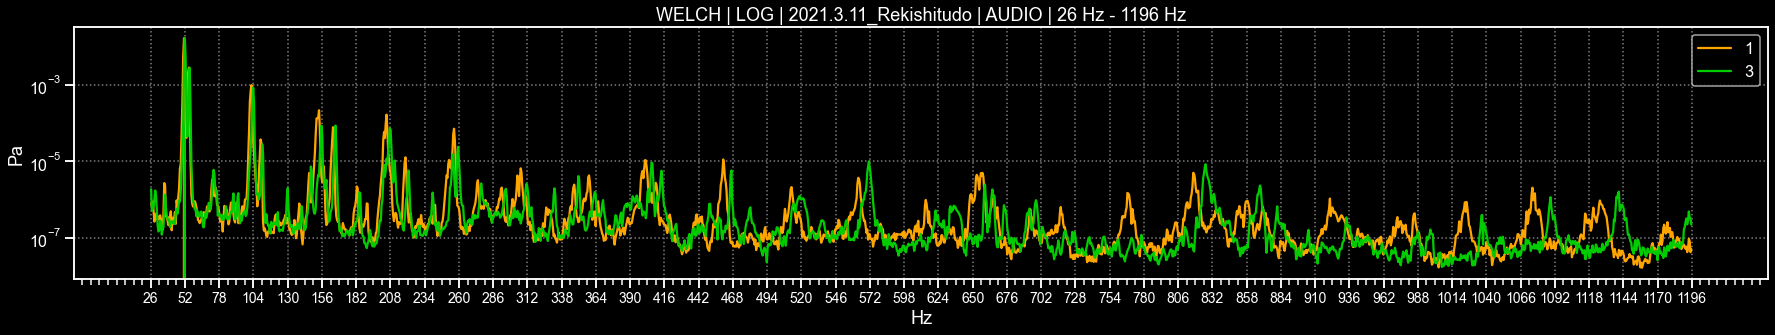

In [299]:
# graph(3, 4, 0, 4, LTH, HTH, ft=ft)
compose(3, 4, 4, LTH, HTH, ignore=[2], visual_m=vm, ft=ft)

---

### GAUSSIAN MEMBERSHIP FUNCTIONS

In [300]:
raw_data = np.genfromtxt(f'data/{PATH}/CLEANED/{ai}.csv', delimiter=',', unpack=True)

# mean = LTH + FF
sd = 4
r1 = 3
r2 = 5
sc = 2.75

MEAN_1 - 51
MEAN_2 - 102
MEAN_3 - 153
MEAN_4 - 204
MEAN_5 - 255
MEAN_6 - 306
MEAN_7 - 357
MEAN_8 - 408
MEAN_9 - 459
MEAN_10 - 510
MEAN_11 - 561
MEAN_12 - 612
MEAN_13 - 663
MEAN_14 - 714
MEAN_15 - 765
MEAN_16 - 816
MEAN_17 - 867
MEAN_18 - 918
MEAN_19 - 969
MEAN_20 - 1020
MEAN_21 - 1071
MEAN_22 - 1122
MEAN_23 - 1173
******************************************************** ACC_Y ********************************************************
< > Sorted Frequencies (left to right compactions) - [     2   ,      1   ,      3   ]
< > Sorted Frequencies (low to high frequencies)   - [ 43.12500,  51.25000,  51.87500]


'213'

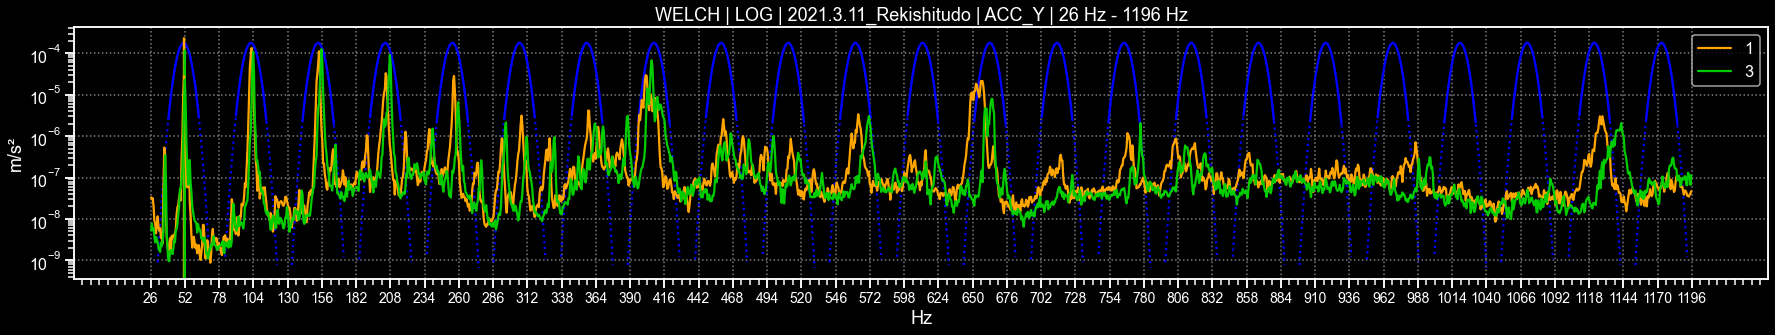

In [301]:
for index, mean in enumerate(range(0, HTH, FF)):
    if mean > LTH:
        y = stats.norm(mean, sd)
        x = bpf(*welch(raw_data[0], raw_data[1]), mean - r1*sd if mean - r1*sd > LTH else LTH, mean + r1*sd if mean + r1*sd < HTH else HTH)[0]
        plt.semilogy(x, y.pdf(x)/(10**sc), color = "blue")
        x = bpf(*welch(raw_data[0], raw_data[1]), mean - r2*sd if mean - r2*sd > LTH else LTH, mean + r2*sd if mean + r2*sd < HTH else HTH)[0]
        plt.semilogy(x, y.pdf(x)/(10**sc), color = "blue", linestyle=":")
        print(f"MEAN_{index} - {mean}")

# graph(3, 4, 0, 1, LTH, HTH, ft=ft)
compose(3, 4, 2, LTH, HTH, ignore=[2], visual_m=vm, ft=ft)

---

## PATTERN ANALYSIS

```QUERY FOR PATTERN ANALYSIS```

### The graph below is of all the patterns determined from the query ran above

In [ ]:
patterns_int = np.array(list(map(lambda pat:int(pat), patterns)))
patterns_str = list(map(lambda pat:str(pat), patterns_int[np.argsort(patterns_int)]))

In [ ]:
sns.countplot(x = patterns_str)

### The graph below is of the patterns, observed from the above query, whose frequencies are greater than *PATTERN_THRESHOLD*

In [ ]:
PATTERN_THRESHOLD = 0

In [ ]:
occurrences = collections.Counter(patterns)
OD = collections.OrderedDict(sorted({key:val for key, val in occurrences.items() if val > PATTERN_THRESHOLD}.items()))

In [ ]:
plt.bar(*zip(*OD.items()))
plt.show()

---

## RI GRAPHS

In [71]:
wet_density = np.array([[1.968, 2.057], [2.083, 2.104], [2.157, 2.156]])
compactness = np.array([[98.1, 101.0], [103.1, 106.5], [107.1, 108.7]])

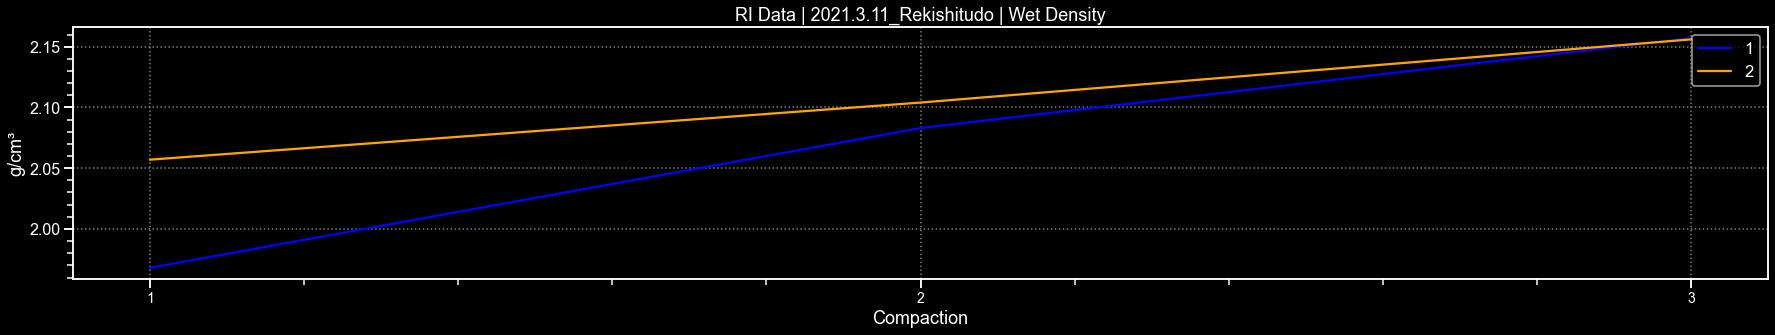

In [302]:
PATH, NUM_COMPACTIONS, COMP_COMPACTIONS = set(3, 4)

plt.plot(np.arange(1,NUM_COMPACTIONS+1), wet_density[:,0], label = "1", color="blue")
plt.plot(np.arange(1,NUM_COMPACTIONS+1), wet_density[:,1], label = "2", color="orange")

plt.xlabel("Compaction")
plt.ylabel("g/cm³")
plt.title(f"RI Data | {PATH} | Wet Density")
plt.legend(loc='best')
plt.tight_layout()
plt.xticks(np.arange(1, NUM_COMPACTIONS+1, 1))
plt.grid(color='gray', linestyle=':')

plt.show()

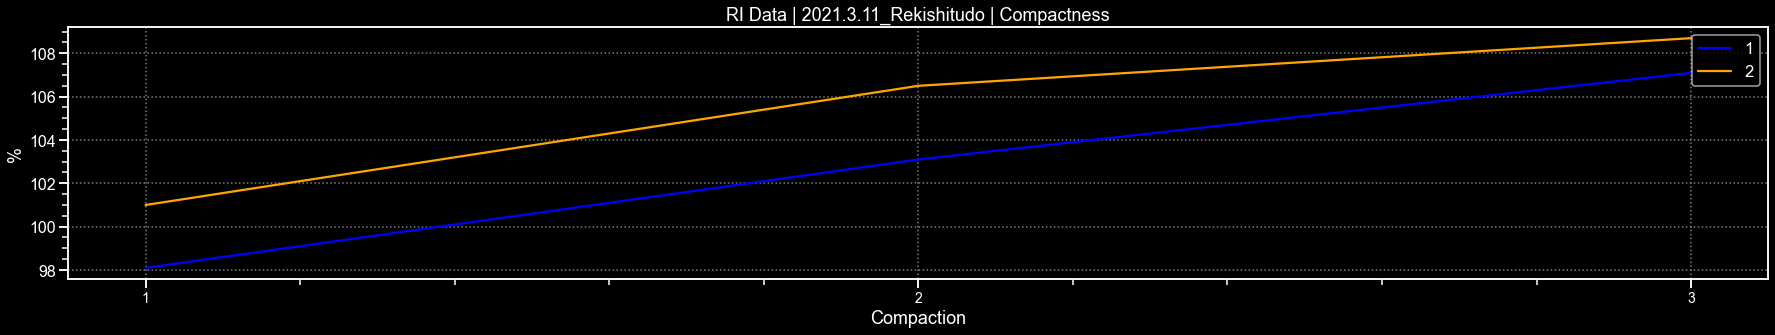

In [303]:
PATH, NUM_COMPACTIONS, COMP_COMPACTIONS = set(3, 4)

plt.plot(np.arange(1,NUM_COMPACTIONS+1), compactness[:,0], label = "1", color="blue")
plt.plot(np.arange(1,NUM_COMPACTIONS+1), compactness[:,1], label = "2", color="orange")

plt.xlabel("Compaction")
plt.ylabel("%")
plt.title(f"RI Data | {PATH} | Compactness")
plt.legend(loc='best')
plt.tight_layout()
plt.xticks(np.arange(1, NUM_COMPACTIONS+1, 1))
plt.grid(color='gray', linestyle=':')

plt.show()

---

In [306]:
!jupyter nbconvert --to='python' test.ipynb

C:\Users\Pulkit\anaconda3\lib\site-packages\traitlets\traitlets.py:2196: FutureWarning: Supporting extra quotes around Unicode is deprecated in traitlets 5.0. Use 'python' instead of "'python'" \u2013 or use CUnicode.
  warn(
[NbConvertApp] Converting notebook test.ipynb to python
[NbConvertApp] Writing 20297 bytes to test.py
